In [7]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["font.size"] = 14

np.random.seed(1942)

**Set up**

In [8]:
x, y = np.linspace(-0.5, 0.5, 201), np.linspace(-0.5, 0.5, 201)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

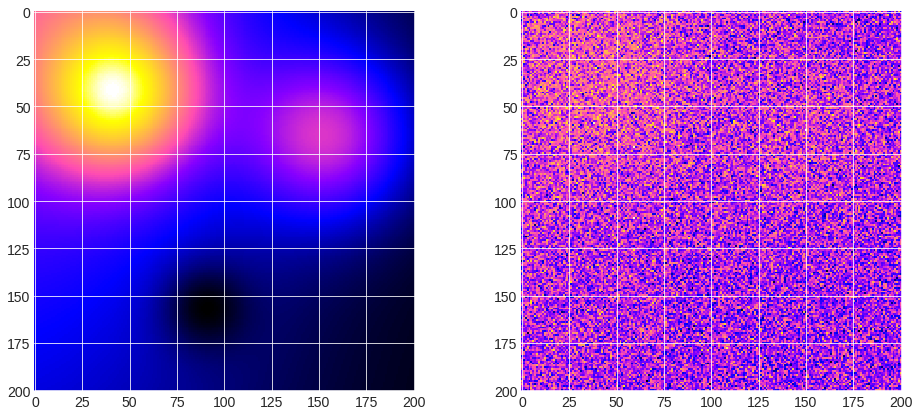

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = FrankeCentered(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

**OLS**

fitting 

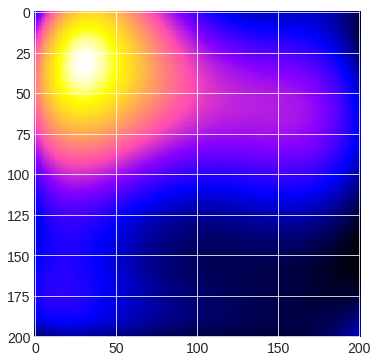

In [24]:
beta = reg.solveCoefficients(poly_order=5, solver="OLS")
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh)

plt.imshow(data_pred);

Error 

In [11]:
mse = MSE(reg.f, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred)
print("metrics vs noisy franke (data trained on): ", mse, rmse, rrmse, r2)

mse = MSE(franke_noiseless, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred)
print("metrics vs noiseless franke: ", mse, rmse, rrmse, r2)

metrics vs noisy franke (data trained on):  1.0049810715222927 1.0024874420771028 2.4854340034189 0.04588688799307474
metrics vs noiseless franke:  0.0022954004996799033 0.047910338129467454 0.11878251886682187 0.9417029417136777


**OLS K-FOLDING**

In [12]:
data_pred = reg.solveKFold(K=10, poly_order=5, solver="OLS")

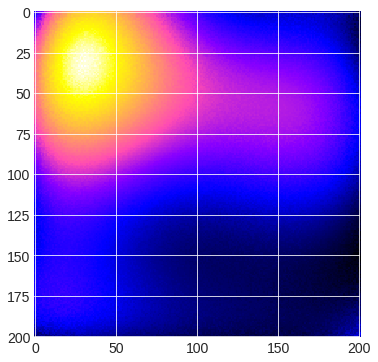

In [13]:
plt.imshow(data_pred)

In [21]:
data_pred_list = []
for i in trange(5, 40, 2):
    K = i
    data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")
    data_pred_list.append(data_pred)

100%|██████████| 18/18 [00:25<00:00,  1.44s/it]


In [22]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
for i in range(len(data_pred_list)):
    data_pred = data_pred_list[i]
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

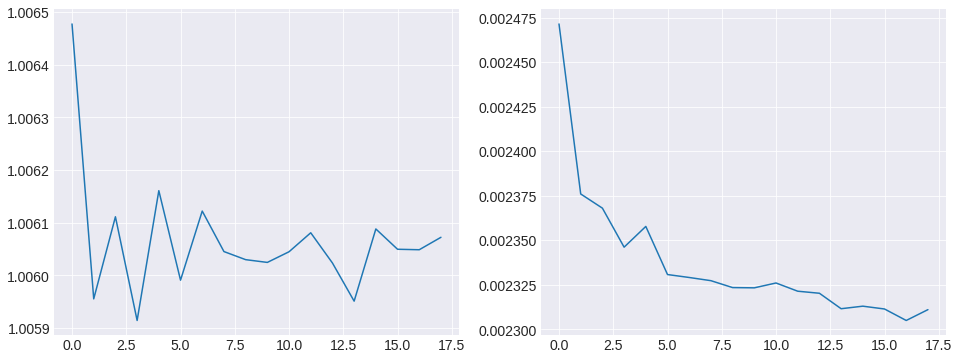

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(mse_list);
ax2.plot(mse_list_noiseless);

**RIDGE**

In [25]:
data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge")

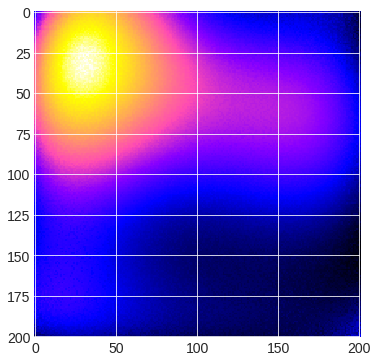

In [26]:
plt.imshow(data_pred);

In [27]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
lamda_list = np.logspace(-1, -8, 16)
for i in trange(len(lamda_list)):
    lamda = lamda_list[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge", lamda=lamda)
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


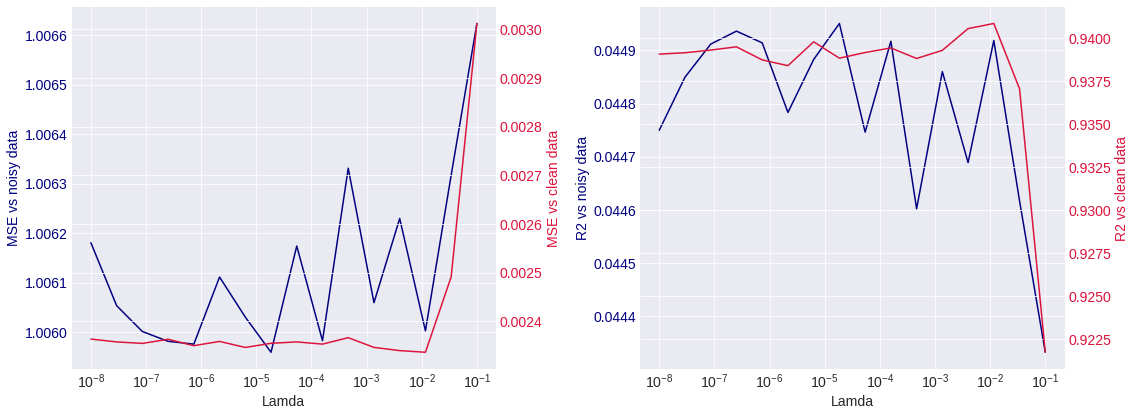

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.semilogx(lamda_list, mse_list, c="navy", label="MSE vs noisy data");
ax11.semilogx(lamda_list, mse_list_noiseless, c="crimson", label="MSE vs clean data");
ax2.semilogx(lamda_list, r2_list, c="navy");
ax22.semilogx(lamda_list, r2_list_noiseless, c="crimson");
ax1.set_xlabel("Lamda")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("MSE vs clean data", color="crimson");
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
ax2.set_xlabel("Lamda")
ax2.set_ylabel("R2 vs noisy data", color="navy");
ax22.set_ylabel("R2 vs clean data", color="crimson");
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.tight_layout()

In [40]:
reg.solveCoefficients(solver="Ridge")

array([ -0.0486739 ,  -1.53634485,   0.50002759,   9.28519071,
        -4.04318522, -17.02140712,  -0.19435552,   1.60086882,
        -6.94591188,  -0.82190534,  17.5060965 ,   2.08940425,
        -3.13417663,   0.3911304 ,  -1.86090843,  -1.87025989,
        -4.28714026,  12.98851282,  -9.44932785,  18.57610138,
         7.18301501])

**LASSO**

In [30]:
data_pred_Kfold = reg.solveKFold(K=10,poly_order=5,solver='Lasso')

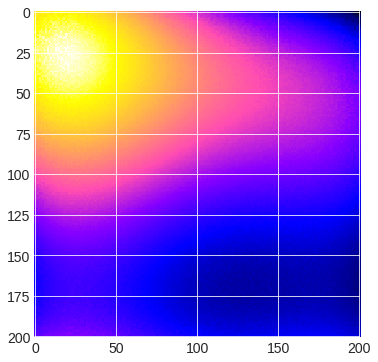

In [31]:
plt.imshow(data_pred_Kfold)

In [35]:
mse = MSE(reg.f, data_pred_Kfold)
mse

1.0095927995235743

In [37]:
reg.solveCoefficients(solver="Lasso")

array([-0.00447946, -1.28807822, -0.17496454,  4.04086565, -0.69736925,
        0.        , -0.53216836,  0.89887324, -0.99772984, -0.        ,
        0.        ,  0.98116475,  0.37664714,  0.        ,  0.        ,
        0.92484149, -0.56843457,  0.        , -4.26500949,  0.        ,
        0.        ])